In [1]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [2]:
df =pd.read_sql_table('display', 'sqlite:///dissertation.db') 

In [3]:
df_copy = df.copy()

In [4]:
df_copy

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
0,2019-12-23 00:00:00,21.0,-1,0,0,0,weekday,0.000058
1,2019-12-23 00:00:10,21.0,-1,0,0,0,weekday,0.000058
2,2019-12-23 00:00:20,21.0,-1,0,0,0,weekday,0.000058
3,2019-12-23 00:00:30,21.0,-1,0,0,0,weekday,0.000058
4,2019-12-23 00:00:40,21.0,-1,0,0,0,weekday,0.000058
...,...,...,...,...,...,...,...,...
1451515,2020-06-07 23:59:10,58.0,23,6,23,59,holiday,0.000161
1451516,2020-06-07 23:59:20,58.0,23,6,23,59,holiday,0.000161
1451517,2020-06-07 23:59:30,57.5,23,6,23,59,holiday,0.000160
1451518,2020-06-07 23:59:40,57.0,23,6,23,59,holiday,0.000158


In [5]:
# group by half an hour, and change kWh to Wh in order to enlarge the number
df_half = pd.DataFrame ({'Half_Wh':(df_copy.groupby(pd.Grouper(freq='30T',key='time'))['kWh'].sum().ffill()*1000)})

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [7]:
# subset 80% of dataset for train and test, 20% for future input  
subset = 6451
df_train_test = df_half[['Half_Wh']][:subset]
df_simu = df_half[['Half_Wh']][subset:]

# transform 
train_test=df_train_test.values
train_test=train_test.astype('float32')

simu=df_simu.values
simu=simu.astype('float32')

In [8]:
# split into train and test sets
train_size = int(len(train_test) * 0.75)
test_size = len(train_test) - train_size
train, test = train_test[0:train_size], train_test[train_size:len(train_test)]
print(len(train), len(test))

4838 1613


In [9]:
# manipulate data to x,and y
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
look_back=48
trainX, trainY = create_dataset(train,look_back)
testX, testY = create_dataset(test,look_back)
simuX, simuY = create_dataset(simu,look_back)

In [11]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=48, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae','mape'])
history=model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 2s - loss: 294.3898 - mse: 294.3897 - mae: 10.2132 - mape: 239950240.0000
Epoch 2/200
 - 2s - loss: 266.7607 - mse: 266.7608 - mae: 10.3250 - mape: 692859648.0000
Epoch 3/200
 - 2s - loss: 243.4283 - mse: 243.4285 - mae: 10.0336 - mape: 535800448.0000
Epoch 4/200
 - 2s - loss: 220.2322 - mse: 220.2324 - mae: 9.4454 - mape: 261807328.0000
Epoch 5/200
 - 2s - loss: 198.8669 - mse: 198.8669 - mae: 9.0485 - mape: 221537232.0000
Epoch 6/200
 - 2s - loss: 177.6225 - mse: 177.6224 - mae: 8.5400 - mape: 226833280.0000
Epoch 7/200
 - 2s - loss: 156.5616 - mse: 156.5619 - mae: 7.8915 - mape: 204333984.0000
Epoch 8/200
 - 2s - loss: 137.2187 - mse: 137.2187 - mae: 7.3960 - mape: 222236016.0000
Epoch 9/200
 - 2s - loss: 120.1914 - mse: 120.1912 - mae: 6.9680 - mape: 205760480.0000
Epoch 10/200
 - 2s - loss: 104.5685 - mse: 104.5686 - mae: 6.5392 - mape: 220611776.0

Epoch 89/200
 - 2s - loss: 10.9841 - mse: 10.9840 - mae: 1.4770 - mape: 137064704.0000
Epoch 90/200
 - 2s - loss: 10.9789 - mse: 10.9789 - mae: 1.4836 - mape: 148464256.0000
Epoch 91/200
 - 2s - loss: 11.0926 - mse: 11.0926 - mae: 1.4869 - mape: 147901296.0000
Epoch 92/200
 - 2s - loss: 10.8391 - mse: 10.8390 - mae: 1.4954 - mape: 142431440.0000
Epoch 93/200
 - 2s - loss: 11.0670 - mse: 11.0670 - mae: 1.5102 - mape: 148620096.0000
Epoch 94/200
 - 2s - loss: 10.9521 - mse: 10.9521 - mae: 1.4864 - mape: 141111520.0000
Epoch 95/200
 - 3s - loss: 10.8233 - mse: 10.8233 - mae: 1.4708 - mape: 139930352.0000
Epoch 96/200
 - 2s - loss: 10.8861 - mse: 10.8861 - mae: 1.4924 - mape: 131416760.0000
Epoch 97/200
 - 3s - loss: 10.7464 - mse: 10.7464 - mae: 1.4753 - mape: 142306192.0000
Epoch 98/200
 - 2s - loss: 10.7673 - mse: 10.7672 - mae: 1.4765 - mape: 145227072.0000
Epoch 99/200
 - 2s - loss: 11.0160 - mse: 11.0160 - mae: 1.4704 - mape: 142535264.0000
Epoch 100/200
 - 2s - loss: 10.7560 - mse: 

Epoch 183/200
 - 2s - loss: 9.7626 - mse: 9.7627 - mae: 1.3965 - mape: 122345600.0000
Epoch 184/200
 - 2s - loss: 9.8025 - mse: 9.8025 - mae: 1.3883 - mape: 116696464.0000
Epoch 185/200
 - 2s - loss: 9.5349 - mse: 9.5350 - mae: 1.3844 - mape: 117751264.0000
Epoch 186/200
 - 2s - loss: 9.6337 - mse: 9.6337 - mae: 1.3960 - mape: 116678696.0000
Epoch 187/200
 - 2s - loss: 9.7507 - mse: 9.7507 - mae: 1.4048 - mape: 128433808.0000
Epoch 188/200
 - 2s - loss: 9.6700 - mse: 9.6700 - mae: 1.4079 - mape: 122515752.0000
Epoch 189/200
 - 2s - loss: 9.6762 - mse: 9.6762 - mae: 1.4018 - mape: 123569600.0000
Epoch 190/200
 - 2s - loss: 9.7527 - mse: 9.7527 - mae: 1.3977 - mape: 128311608.0000
Epoch 191/200
 - 2s - loss: 9.7426 - mse: 9.7426 - mae: 1.4092 - mape: 122919360.0000
Epoch 192/200
 - 2s - loss: 9.6736 - mse: 9.6736 - mae: 1.3763 - mape: 113636224.0000
Epoch 193/200
 - 2s - loss: 9.5682 - mse: 9.5682 - mae: 1.3950 - mape: 118623688.0000
Epoch 194/200
 - 2s - loss: 9.6429 - mse: 9.6429 - mae

In [12]:
# model evalute
trainScore = model.evaluate(trainX, trainY)
testScore = model.evaluate(testX, testY)
#validScore = model.evaluate(validX, validY)

print('Train MSE: ', trainScore[1], 'MAE: ', trainScore[2])
print('Test MSE: ', testScore[1], 'MAE: ', testScore[2])
#print('Valid MSE: ', validScore[1], 'MAE: ', validScore[2])
    

1564/1564 [==============================] - 0s 18us/step
Train MSE:  9.213890075683594 MAE:  1.2439178228378296
Test MSE:  0.7185323238372803 MAE:  0.6863126754760742


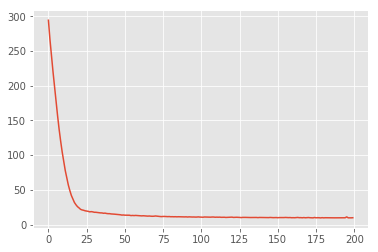

In [13]:
plt.plot(history.history['loss'])

In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
simuPredict = model.predict(simuX)
nextPredict = model.predict(testX[-1:,:])

In [15]:
print(nextPredict,df_simu[0:1].values)

[[35.462975]] [[35.5]]


In [16]:
from sklearn.metrics import r2_score
r2_score(testY,testPredict)

0.9279896971806934

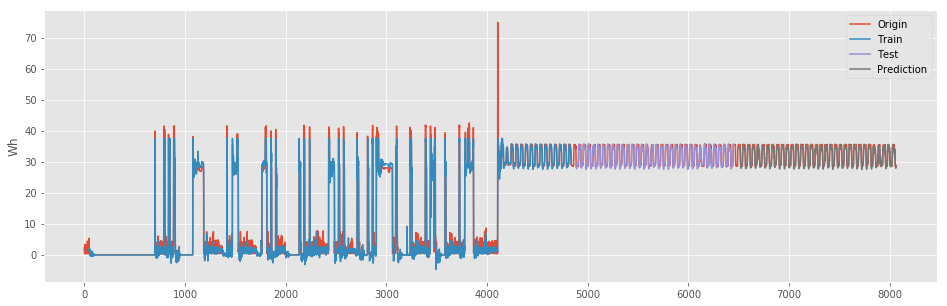

In [17]:
trainPredictPlot = np.empty_like(train_test)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(train_test)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train_test)-1, :] = testPredict

np_all = np.concatenate((train_test,simu),axis=0)
simuPredictPlot = np.empty_like(np_all)
simuPredictPlot[:, :] = np.nan
simuPredictPlot[len(train_test)+look_back:-1, :] = simuPredict


#add time range

# plot baseline and predictions
plt.figure(figsize=(16,5))
plt.plot(np_all,label='Origin')
plt.plot(trainPredictPlot,label='Train')
plt.plot(testPredictPlot,label='Test')
plt.plot(simuPredictPlot,label='Prediction')
plt.legend()
plt.ylabel('Wh')
plt.show()

In [18]:
# plot graph with time in xaxis, add time and plot
time_index = pd.date_range(start='12/23/2019 00:00:00', end='6/07/2020 23:30:00', freq='30T')
df_all = pd.DataFrame(np_all,columns={'Actual'}).set_index(time_index)
df_trainPredictPlot = pd.DataFrame(trainPredictPlot,columns={'Train'}).set_index(time_index[:subset])
df_testPredictPlot = pd.DataFrame(testPredictPlot,columns={'Test'}).set_index(time_index[:subset])
df_simuPredictPlot = pd.DataFrame(simuPredictPlot,columns={'Prediction'}).set_index(time_index)
df_all_plot = pd.concat([df_all, df_trainPredictPlot,df_testPredictPlot,df_simuPredictPlot], axis=1)

Text(0, 0.5, 'Wh')

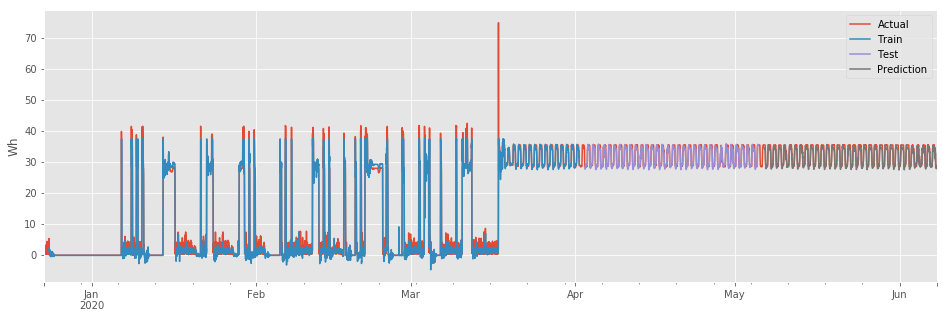

In [19]:
df_all_plot.set_index(df_all_plot.index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

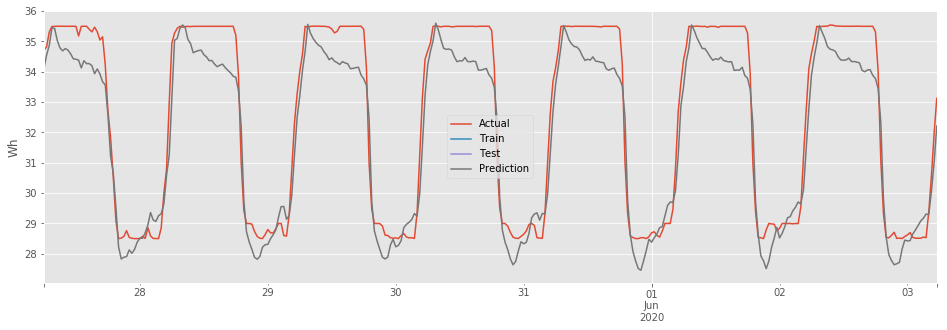

In [20]:
df_all_plot[7500:7836].set_index(df_all_plot[7500:7836].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

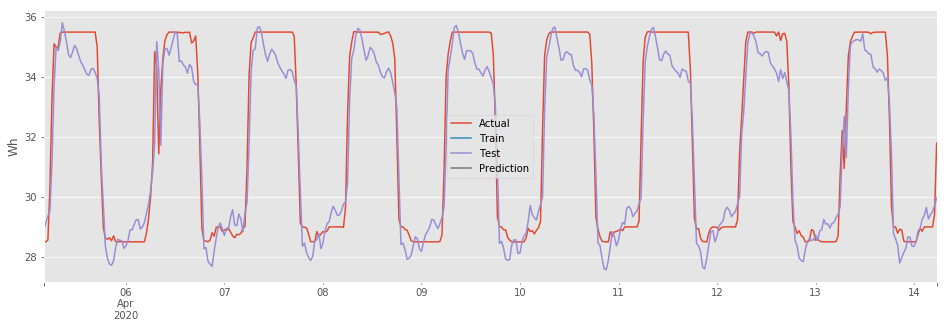

In [22]:
df_all_plot[5000:5436].set_index(df_all_plot[5000:5436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

Text(0, 0.5, 'Wh')

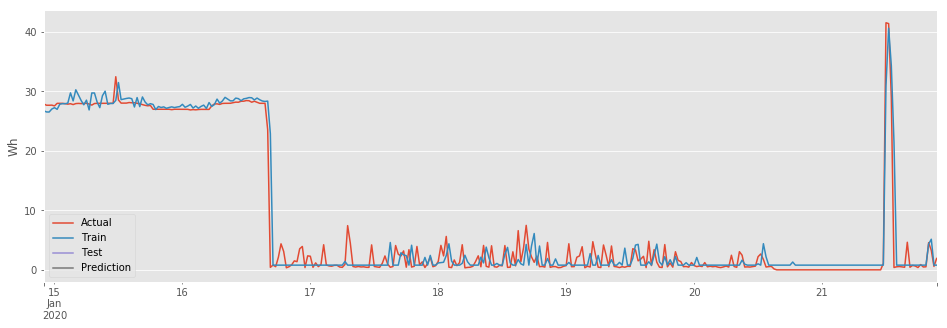

In [37]:
df_all_plot[1100:1436].set_index(df_all_plot[1100:1436].index).plot(figsize=(16,5))
plt.ylabel('Wh')

In [23]:
# save the model 
model.save('display_ann.h5')

In [31]:
# with lockdown
mad_mean_ratio =0.69*1613/df_half['Half_Wh'][6451-1613:6451].sum() 
mad_mean_ratio

0.02155071143925952